## Libraries

In [ ]:
!pip install tensorflow==2.2.0
!pip install scipy==1.2.1
!pip install tensorlayer
# !pip install tensorflow

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 92kB/s 
     |████████████████████████████████| 460kB 38.7MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 24.8MB 1.6MB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import (Input, Conv2d, BatchNorm2d, Elementwise, SubpixelConv2d, Flatten, Dense)
from tensorlayer.models import Model
tf.__version__

'2.2.0'

In [ ]:
# import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict
import json
import os
import time
import random
import numpy as np
import pandas as pd
import scipy, multiprocessing
from tensorflow.keras.preprocessing import image
#from model import get_G, get_D
#from config import config

## Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [ ]:
# !unzip -q "DIV2K_valid_LR_bicubic_X4.zip" -d "/content/drive/My Drive/AML_final_project/"
# !unzip -q "DIV2K_train_LR_bicubic_X4.zip" -d "/content/drive/My Drive/AML_final_project/"
# !unzip -q "DIV2K_train_HR.zip" -d "/content/drive/My Drive/AML_final_project/"
# !unzip -q "DIV2K_valid_HR.zip" -d "/content/drive/My Drive/AML_final_project/"

## Model

In [ ]:
def get_G(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)

    nin = Input(input_shape)
    n = Conv2d(64, (3, 3), (1, 1), act=tf.nn.relu,
               padding='SAME', W_init=w_init)(nin)
    temp = n

    def get_G_res_block(n, w_init, g_init):
        nn = Conv2d(64, (3, 3), (1, 1), padding='SAME',
                    W_init=w_init, b_init=None)(n)
        nn = BatchNorm2d(act=tf.nn.relu, gamma_init=g_init)(nn)
        nn = Conv2d(64, (3, 3), (1, 1), padding='SAME',
                    W_init=w_init, b_init=None)(nn)
        nn = BatchNorm2d(gamma_init=g_init)(nn)
        nn = Elementwise(tf.add)([n, nn])
        return nn

    def get_conv_block(n, w_init):
        n = Conv2d(256, (3, 3), (1, 1), padding='SAME', W_init=w_init)(n)
        n = SubpixelConv2d(scale=2, n_out_channels=None, act=tf.nn.relu)(n)
        return n

    # B residual blocks
    for _ in range(16):
        n = get_G_res_block(n, w_init, g_init)

    n = Conv2d(64, (3, 3), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(gamma_init=g_init)(n)
    n = Elementwise(tf.add)([n, temp])
    # B residual blacks end

    for _ in range(2):
      n = get_conv_block(n, w_init)

    nn = Conv2d(3, (1, 1), (1, 1), act=tf.nn.tanh,
                padding='SAME', W_init=w_init)(n)
    G = Model(inputs=nin, outputs=nn) # , name="generator"
    return G


def get_D(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    df_dim = 64
    def lrelu(x): return tl.act.lrelu(x, 0.2)

    nin = Input(input_shape)
    n = Conv2d(df_dim, (4, 4), (2, 2), act=lrelu,
               padding='SAME', W_init=w_init)(nin)

    n = Conv2d(df_dim * 2, (4, 4), (2, 2), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 4, (4, 4), (2, 2), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (4, 4), (2, 2), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 16, (4, 4), (2, 2), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 32, (4, 4), (2, 2), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 16, (1, 1), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (1, 1), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(n)
    nn = BatchNorm2d(gamma_init=gamma_init)(n)

    n = Conv2d(df_dim * 2, (1, 1), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(nn)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 2, (3, 3), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (3, 3), (1, 1), padding='SAME',
               W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(gamma_init=gamma_init)(n)
    n = Elementwise(combine_fn=tf.add, act=lrelu)([n, nn])

    n = Flatten()(n)
    no = Dense(n_units=1, W_init=w_init)(n)
    D = Model(inputs=nin, outputs=no) # , name="discriminator"
    return D

## Config

In [ ]:
config = edict()
config.TRAIN = edict()

## Adam
config.TRAIN.batch_size = 8 # [16] use 8 if your GPU memory is small, and use [2, 4] in tl.vis.save_images / use 16 for faster training
config.TRAIN.lr_init = 1e-4
config.TRAIN.beta1 = 0.9

## initialize G
config.TRAIN.n_epoch_init = 100 #100
    # config.TRAIN.lr_decay_init = 0.1
    # config.TRAIN.decay_every_init = int(config.TRAIN.n_epoch_init / 4) # 2

## adversarial learning (SRGAN)
config.TRAIN.n_epoch = 100 #2000
config.TRAIN.lr_decay = 0.1
config.TRAIN.decay_every = int(config.TRAIN.n_epoch / 2) # 2

## train set location
config.TRAIN.hr_img_path = '/content/drive/MyDrive/AML_final_project/landscapes/TRAIN_HR/'
config.TRAIN.hr_spec_img_path = '/content/drive/MyDrive/AML_final_project/landscapes/3/'    # mountains
# config.TRAIN.hr_img_path = '/content/drive/MyDrive/AML_final_project/DIV2K_train_HR/'
# config.TRAIN.lr_img_path = '/content/drive/MyDrive/AML_final_project/DIV2K_train_LR_bicubic/X4/'

config.VALID = edict()
## test set location
config.VALID.hr_img_path = '/content/drive/MyDrive/AML_final_project/landscapes/VALID_HR/'
# config.VALID.hr_img_path = '/content/drive/MyDrive/AML_final_project/DIV2K_valid_HR/'
# config.VALID.lr_img_path = '/content/drive/MyDrive/AML_final_project/DIV2K_valid_LR_bicubic/X4/'

print(config)

def log_config(filename, cfg):
    with open(filename, 'w') as f:
        f.write("================================================\n")
        f.write(json.dumps(cfg, indent=4))
        f.write("\n================================================\n")


{'TRAIN': {'batch_size': 8, 'lr_init': 0.0001, 'beta1': 0.9, 'n_epoch_init': 100, 'n_epoch': 100, 'lr_decay': 0.1, 'decay_every': 50, 'hr_img_path': '/content/drive/MyDrive/AML_final_project/landscapes/TRAIN_HR/', 'hr_spec_img_path': '/content/drive/MyDrive/AML_final_project/landscapes/3/'}, 'VALID': {'hr_img_path': '/content/drive/MyDrive/AML_final_project/landscapes/VALID_HR/'}}


##Main Functions



In [ ]:
###====================== HYPER-PARAMETERS ===========================###
## Adam
batch_size = config.TRAIN.batch_size  # use 8 if your GPU memory is small, and change [4, 4] in tl.vis.save_images to [2, 4]
lr_init = config.TRAIN.lr_init
beta1 = config.TRAIN.beta1
## initialize G
n_epoch_init = config.TRAIN.n_epoch_init
## adversarial learning (SRGAN)
n_epoch = config.TRAIN.n_epoch
lr_decay = config.TRAIN.lr_decay
decay_every = config.TRAIN.decay_every
shuffle_buffer_size = 128
n_images = 100
# ni = int(np.sqrt(batch_size))

# create folders to save result images and trained models
save_dir = "/content/drive/MyDrive/AML_final_project/samples"
tl.files.exists_or_mkdir(save_dir)
checkpoint_dir = "/content/drive/MyDrive/AML_final_project/models"
tl.files.exists_or_mkdir(checkpoint_dir)


def get_train_data(generic = True):
    # load dataset
    if generic:
      path = config.TRAIN.hr_img_path
    else:
      path = config.TRAIN.hr_spec_img_path

    train_hr_img_list = sorted(tl.files.load_file_list(path=path, regx='.*.jpg', printable=False))[:n_images]
      
        # train_lr_img_list = sorted(tl.files.load_file_list(path=config.TRAIN.lr_img_path, regx='.*.png', printable=False))
        # valid_hr_img_list = sorted(tl.files.load_file_list(path=config.VALID.hr_img_path, regx='.*.png', printable=False))
        # valid_lr_img_list = sorted(tl.files.load_file_list(path=config.VALID.lr_img_path, regx='.*.png', printable=False))

    ## If your machine have enough memory, please pre-load the entire train set.
    train_hr_imgs = tl.vis.read_images(train_hr_img_list, path=path, n_threads=32)
        # for im in train_hr_imgs:
        #     print(im.shape)
        # valid_lr_imgs = tl.vis.read_images(valid_lr_img_list, path=config.VALID.lr_img_path, n_threads=32)
        # for im in valid_lr_imgs:
        #     print(im.shape)
        # valid_hr_imgs = tl.vis.read_images(valid_hr_img_list, path=config.VALID.hr_img_path, n_threads=32)
        # for im in valid_hr_imgs:
        #     print(im.shape)
        
    # dataset API and augmentation
    def generator_train():
        for img in train_hr_imgs:
            yield img

    def _map_fn_train(img):
        hr_patch = tf.image.random_crop(img, [384, 384, 3])
        hr_patch = hr_patch / (255. / 2.)
        hr_patch = hr_patch - 1.
        
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        hr_patch = tf.image.random_brightness(hr_patch, max_delta=0.4)
        hr_patch = tf.image.random_contrast(hr_patch, lower=0.1, upper=0.4)
        lr_patch = tf.image.resize(hr_patch, size=[96, 96], 
                                    method='bicubic') # or method='bilinear')
        return lr_patch, hr_patch
          
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=(tf.float32))
    train_ds = train_ds.map(_map_fn_train, num_parallel_calls=multiprocessing.cpu_count())
        # train_ds = train_ds.repeat(n_epoch_init + n_epoch)
    train_ds = train_ds.shuffle(shuffle_buffer_size)
    train_ds = train_ds.prefetch(buffer_size=2)
    train_ds = train_ds.batch(batch_size)
        # value = train_ds.make_one_shot_iterator().get_next()
    return train_ds


def train(g_pretrained=False, n_trainable=None, generic=True):
      total_time = time.time()
    # with tf.device('/device:GPU:0'): # aggiunto Ale
      G = get_G((batch_size, 96, 96, 3))
      D = get_D((batch_size, 384, 384, 3))
      VGG = tl.models.vgg16(pretrained=True, end_with='pool4', mode='static')  #era vgg19 ma non funziona più

      if generic:
        g_name = 'g'
        d_name = 'd'
      else:
        g_name = 'g_spec'
        d_name = 'd_spec'

      lr_v = tf.Variable(lr_init)
      g_optimizer_init = tf.optimizers.Adam(lr_v, beta_1=beta1)
      g_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)
      d_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)

      G.train()
      D.train()
      VGG.train()

      train_ds = get_train_data(generic)

      trainable_weights = G.trainable_weights

      if g_pretrained and n_trainable:
        G.load_weights(os.path.join(checkpoint_dir, 'g_srgan.npz'))
        nt = -n_trainable-1
        trainable_weights = G.all_weights[:nt]

      g_init_losses = []
      # initialize learning (G)
      n_step_epoch = round(n_epoch_init // batch_size)
      for epoch in range(n_epoch_init):
          for step, (lr_patchs, hr_patchs) in train_ds.enumerate():
              # if the remaining data in this epoch < batch_size
              if lr_patchs.shape[0] != batch_size:
                  break
              step_time = time.time()
              with tf.GradientTape() as tape:
                  G.all_weights[:nt] = trainable_weights
                  fake_hr_patchs = G(lr_patchs)
                  mse_loss = tl.cost.mean_squared_error(
                      fake_hr_patchs, hr_patchs, is_mean=True)
              grad = tape.gradient(mse_loss, trainable_weights)
              g_optimizer_init.apply_gradients(zip(grad, trainable_weights))
              print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, mse: {:.3f} ".format(
                  epoch, n_epoch_init, step, n_step_epoch, time.time() - step_time, mse_loss))
          if (epoch != 0) and (epoch % 10 == 0):
              tl.vis.save_images(fake_hr_patchs.numpy(), [2, 4], os.path.join(
                  save_dir, 'train_g_init_{}.png'.format(epoch)))
      # aggiunto Ale
      tl.vis.save_images(fake_hr_patchs.numpy(), [2, 4], os.path.join(save_dir, 'train_g_init_final.png'))

      ## adversarial learning (G, D)
      n_step_epoch = round(n_images // batch_size) # era n_epoch //
      g_losses = []
      d_losses = []
      for epoch in range(n_epoch):
          g_losses_epoch = []
          d_losses_epoch = []
          for step, (lr_patchs, hr_patchs) in enumerate(train_ds):
              if lr_patchs.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
                  break
              step_time = time.time()
              with tf.GradientTape(persistent=True) as tape:
                  fake_patchs = G(lr_patchs)
                  logits_fake = D(fake_patchs)
                  logits_real = D(hr_patchs)
                  feature_fake = VGG((fake_patchs+1)/2.) # the pre-trained VGG uses the input range of [0, 1]
                  feature_real = VGG((hr_patchs+1)/2.)
                  d_loss1 = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(logits_real))
                  d_loss2 = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(logits_fake))
                  d_loss = d_loss1 + d_loss2  # discriminator loss
                  g_gan_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(logits_fake, tf.ones_like(logits_fake))
                  mse_loss = tl.cost.mean_squared_error(fake_patchs, hr_patchs, is_mean=True) 
                  vgg_loss = 2e-6 * tl.cost.mean_squared_error(feature_fake, feature_real, is_mean=True)
                  g_loss = mse_loss + vgg_loss + g_gan_loss # generator loss
              grad = tape.gradient(g_loss, trainable_weights)
              g_optimizer.apply_gradients(zip(grad, trainable_weights))
              grad = tape.gradient(d_loss, D.trainable_weights)
              d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
              print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, g_loss(mse:{:.3f}, vgg:{:.3f}, adv:{:.3f}) d_loss: {:.3f}".format(
                  epoch+1, n_epoch, step+1, n_step_epoch, time.time() - step_time, mse_loss, vgg_loss, g_gan_loss, d_loss))
              g_losses_epoch.append(g_loss.numpy())
              d_losses_epoch.append(d_loss.numpy())
              G.all_weights[:nt] = trainable_weights
          g_losses.append(g_losses_epoch)
          d_losses.append(d_losses_epoch)
          # update the learning rate
          if epoch != 0 and (epoch % decay_every == 0):
              new_lr_decay = lr_decay**(epoch // decay_every)
              lr_v.assign(lr_init * new_lr_decay)
              log = " ** new learning rate: %f (for GAN)" % (lr_init * new_lr_decay)
              print(log)

          if (epoch != 0) and (epoch % 5 == 0): # era epoch%10
              tl.vis.save_images(fake_patchs.numpy(), [2, 4], os.path.join(save_dir, 'train_{}_{}.png'.format(g_name, epoch)))
              G.save_weights(os.path.join(checkpoint_dir, '{}.h5'.format(g_name)))
              D.save_weights(os.path.join(checkpoint_dir, '{}.h5'.format(d_name)))
      # aggiunto Ale
      tl.vis.save_images(fake_patchs.numpy(), [2, 4], os.path.join(save_dir, 'train_{}_final.png'.format(g_name)))
      G.save_weights(os.path.join(checkpoint_dir, '{}.h5'.format(g_name)))
      D.save_weights(os.path.join(checkpoint_dir, '{}.h5'.format(d_name)))

      pd.DataFrame(g_init_losses).to_csv(os.path.join(checkpoint_dir, g_name + '_init_loss.csv'))
      pd.DataFrame(g_losses).to_csv(os.path.join(checkpoint_dir, g_name + '_losses.csv'))
      pd.DataFrame(d_losses).to_csv(os.path.join(checkpoint_dir, d_name + '_losses.csv'))
      print('TOTAL_TIME: ', round((time.time()-total_time)/60,2), 'min')


def evaluate(imid = None, valid_lr_img=None, valid_hr_img=None, landscapes=False, generic=True):

      if imid == None:
        imid = 30

      if generic:
        g_name = 'g'
      else:
        g_name = 'g_spec'

      if valid_lr_img is None:
        ###====================== PRE-LOAD DATA ===========================###
        if landscapes:
          valid_hr_img_list = sorted(tl.files.load_file_list(path=config.VALID.hr_img_path, regx='.*.jpg', printable=False))
          valid_hr_imgs = tl.vis.read_images(valid_hr_img_list, path=config.VALID.hr_img_path, n_threads=32)
          valid_hr_img = valid_hr_imgs[imid]
          w, h, c = valid_hr_img.shape
          valid_lr_img = tf.image.resize(valid_hr_img, size=[w//4, h//4], method='bicubic')
        else:
          valid_lr_img_list = sorted(tl.files.load_file_list(path=config.VALID.lr_img_path, regx='.*.png', printable=False))
          valid_lr_imgs = tl.vis.read_images(valid_lr_img_list, path=config.VALID.lr_img_path, n_threads=32)
          valid_lr_img = valid_lr_imgs[imid]

        ###========================== DEFINE MODEL ============================###

      valid_lr_img = (valid_lr_img / 127.5) - 1  # rescale to ［－1, 1]

      G = get_G([1, None, None, 3])
      G.load_weights(os.path.join(checkpoint_dir, '{}.h5'.format(g_name))) # 'g.h5' 'g_spec.h5 'g_srgan.npz'
      G.eval()

      valid_lr_img = np.asarray(valid_lr_img, dtype=np.float32)
      valid_lr_img = valid_lr_img[np.newaxis,:,:,:]
      size = [valid_lr_img.shape[1], valid_lr_img.shape[2]]

      out = G(valid_lr_img).numpy()

      print("LR size: %s /  generated HR size: %s" % (size, out.shape))  # LR size: (339, 510, 3) /  gen HR size: (1, 1356, 2040, 3)
      print("[*] save images")
      tl.vis.save_image(out[0], os.path.join(save_dir, 'valid_gen.png'))
      tl.vis.save_image(valid_lr_img[0], os.path.join(save_dir, 'valid_lr.png'))
      # if valid_hr_img is not None:
        # tl.vis.save_image(valid_hr_img, os.path.join(save_dir, 'valid_hr.png'))

      out_bicu = scipy.misc.imresize(valid_lr_img[0], [size[0] * 4, size[1] * 4], interp='bicubic', mode=None)
      # out_bicu = np.array(Image.fromarray(valid_lr_img[0]).resize([int(size[0] * 4), int(size[1] * 4)],resample=PIL.Image.BICUBIC))
      tl.vis.save_image(out_bicu, os.path.join(save_dir, 'valid_bicubic.png'))

      return out

[TL] [!] /content/drive/MyDrive/AML_final_project/samples exists ...
[TL] [!] /content/drive/MyDrive/AML_final_project/models exists ...


## Train

In [ ]:
train(g_pretrained=True, n_trainable=1)

[TL] Input  _inputlayer_1: (8, 96, 96, 3)
[TL] Conv2d conv2d_1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_2: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_3: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_2: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_1: fn: add act: No Activation
[TL] Conv2d conv2d_4: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_5: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_4: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_2

100% (67559 of 67559) |##################| Elapsed Time: 0:01:24 ETA:  00:00:00

[TL] Succesfully downloaded vgg16_weights.npz 553436134 bytes.
[TL]   Loading weights (3, 3, 3, 64) in conv1_1_W
[TL]   Loading weights (64,) in conv1_1_b
[TL]   Loading weights (3, 3, 64, 64) in conv1_2_W
[TL]   Loading weights (64,) in conv1_2_b
[TL]   Loading weights (3, 3, 64, 128) in conv2_1_W
[TL]   Loading weights (128,) in conv2_1_b
[TL]   Loading weights (3, 3, 128, 128) in conv2_2_W
[TL]   Loading weights (128,) in conv2_2_b
[TL]   Loading weights (3, 3, 128, 256) in conv3_1_W
[TL]   Loading weights (256,) in conv3_1_b
[TL]   Loading weights (3, 3, 256, 256) in conv3_2_W
[TL]   Loading weights (256,) in conv3_2_b
[TL]   Loading weights (3, 3, 256, 256) in conv3_3_W
[TL]   Loading weights (256,) in conv3_3_b
[TL]   Loading weights (3, 3, 256, 512) in conv4_1_W
[TL]   Loading weights (512,) in conv4_1_b
[TL]   Loading weights (3, 3, 512, 512) in conv4_2_W
[TL]   Loading weights (512,) in conv4_2_b
[TL]   Loading weights (3, 3, 512, 512) in conv4_3_W
[TL]   Loading weights (512,

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[TL] read 64 from /content/drive/MyDrive/AML_final_project/landscapes/TRAIN_HR/
[TL] read 96 from /content/drive/MyDrive/AML_final_project/landscapes/TRAIN_HR/
[TL] read 100 from /content/drive/MyDrive/AML_final_project/landscapes/TRAIN_HR/
[TL] [*] Load /content/drive/MyDrive/AML_final_project/models/g_srgan.npz SUCCESS!
Epoch: [0/100] step: [0/12] time: 1.652s, mse: 0.103 
Epoch: [0/100] step: [1/12] time: 0.513s, mse: 0.044 
Epoch: [0/100] step: [2/12] time: 0.551s, mse: 0.023 
Epoch: [0/100] step: [3/12] time: 0.474s, mse: 0.017 
Epoch: [0/100] step: [4/12] time: 0.575s, mse: 0.019 
Epoch: [0/100] step: [5/12] time: 0.592s, mse: 0.019 
Epoch: [0/100] step: [6/12] time: 0.724s, mse: 0.025 
Epoch: [0/100] step: [7/12] time: 0.517s, mse: 0.015 
Epoch: [0/100] step: [8/12] time: 0.524s, mse: 0.009 
Epoch: [0/100] step: [9/12] time: 0.586s, mse: 0.010 
Epoch: [0/100] step: [10/12] time: 0.587s, mse: 0.008 
Epoch: [0/100] step: [11/12] time: 0.577s, mse: 0.008 
Epoch: [1/100] step: [0/12

In [ ]:
train(g_pretrained=True, n_trainable=1, generic=False)

[TL] Input  _inputlayer_1: (8, 96, 96, 3)
[TL] Conv2d conv2d_1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_2: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_3: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_2: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_1: fn: add act: No Activation
[TL] Conv2d conv2d_4: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_5: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_4: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_2

100% (67559 of 67559) |##################| Elapsed Time: 0:01:28 ETA:  00:00:00

[TL] Succesfully downloaded vgg16_weights.npz 553436134 bytes.
[TL]   Loading weights (3, 3, 3, 64) in conv1_1_W
[TL]   Loading weights (64,) in conv1_1_b
[TL]   Loading weights (3, 3, 64, 64) in conv1_2_W
[TL]   Loading weights (64,) in conv1_2_b
[TL]   Loading weights (3, 3, 64, 128) in conv2_1_W
[TL]   Loading weights (128,) in conv2_1_b
[TL]   Loading weights (3, 3, 128, 128) in conv2_2_W
[TL]   Loading weights (128,) in conv2_2_b
[TL]   Loading weights (3, 3, 128, 256) in conv3_1_W
[TL]   Loading weights (256,) in conv3_1_b
[TL]   Loading weights (3, 3, 256, 256) in conv3_2_W
[TL]   Loading weights (256,) in conv3_2_b
[TL]   Loading weights (3, 3, 256, 256) in conv3_3_W
[TL]   Loading weights (256,) in conv3_3_b
[TL]   Loading weights (3, 3, 256, 512) in conv4_1_W
[TL]   Loading weights (512,) in conv4_1_b
[TL]   Loading weights (3, 3, 512, 512) in conv4_2_W
[TL]   Loading weights (512,) in conv4_2_b
[TL]   Loading weights (3, 3, 512, 512) in conv4_3_W
[TL]   Loading weights (512,

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[TL] read 64 from /content/drive/MyDrive/AML_final_project/landscapes/3/
[TL] read 96 from /content/drive/MyDrive/AML_final_project/landscapes/3/
[TL] read 100 from /content/drive/MyDrive/AML_final_project/landscapes/3/
[TL] [*] Load /content/drive/MyDrive/AML_final_project/models/g_srgan.npz SUCCESS!
Epoch: [0/100] step: [0/12] time: 1.766s, mse: 0.071 
Epoch: [0/100] step: [1/12] time: 0.573s, mse: 0.060 
Epoch: [0/100] step: [2/12] time: 0.660s, mse: 0.025 
Epoch: [0/100] step: [3/12] time: 0.613s, mse: 0.021 
Epoch: [0/100] step: [4/12] time: 0.594s, mse: 0.021 
Epoch: [0/100] step: [5/12] time: 0.568s, mse: 0.019 
Epoch: [0/100] step: [6/12] time: 0.582s, mse: 0.018 
Epoch: [0/100] step: [7/12] time: 0.604s, mse: 0.009 
Epoch: [0/100] step: [8/12] time: 0.715s, mse: 0.009 
Epoch: [0/100] step: [9/12] time: 0.641s, mse: 0.008 
Epoch: [0/100] step: [10/12] time: 0.569s, mse: 0.020 
Epoch: [0/100] step: [11/12] time: 0.607s, mse: 0.009 
Epoch: [1/100] step: [0/12] time: 0.550s, mse: 

#### Loss plots

In [ ]:
import matplotlib.pyplot as plt

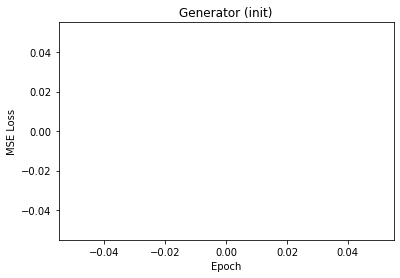

In [ ]:
# GENERATOR INIT
g_init_losses = pd.read_csv(os.path.join(checkpoint_dir, 'g_init_loss.csv'))
l = g_init_losses.iloc[:,1:].mean(axis=1)
plt.plot(range(len(l)), l, )
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Generator (init)')
# plt.text(3, np.max(l)-0.01, 'last='+str(round(l.iloc[-1],3)))
plt.show()

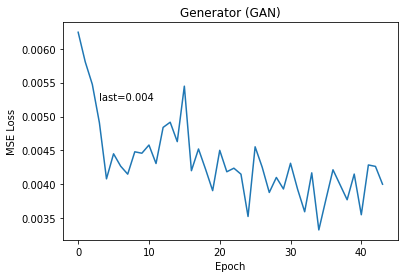

In [ ]:
g_losses = pd.read_csv(os.path.join(checkpoint_dir, 'g_spec_losses.csv'))
l = g_losses.iloc[:,1:].mean(axis=1)
plt.plot(range(len(l)), l, )
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Generator (GAN)')
plt.text(3, np.max(l)-0.001, 'last='+str(round(l.iloc[-1],5)))
plt.show()

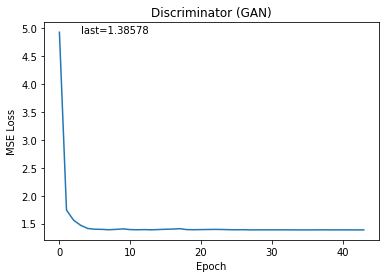

In [ ]:
d_losses = pd.read_csv(os.path.join(checkpoint_dir, 'd_spec_losses.csv'))
l = d_losses.iloc[:,1:].mean(axis=1)
plt.plot(range(len(l)), l, )
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Discriminator (GAN)')
plt.text(3, np.max(l)-0.01, 'last='+str(round(l.iloc[-1],5)))
plt.show()

## Evaluate

In [ ]:
im_sr = evaluate(15, landscapes=True, generic=False)

[TL] read 32 from /content/drive/MyDrive/AML_final_project/landscapes/VALID_HR/


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[TL] read 50 from /content/drive/MyDrive/AML_final_project/landscapes/VALID_HR/
[TL] Input  _inputlayer_15: [1, None, None, 3]
[TL] Conv2d conv2d_393: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_394: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_351: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_395: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_352: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_173: fn: add act: No Activation
[TL] Conv2d conv2d_396: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_353: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_397: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d

Lossy conversion from float32 to uint8. Range [-0.9740507006645203, 0.9677731990814209]. Convert image to uint8 prior to saving to suppress this warning.


LR size: [266, 400] /  generated HR size: (1, 1064, 1600, 3)
[*] save images


Lossy conversion from float32 to uint8. Range [-1.089320421218872, 1.070441722869873]. Convert image to uint8 prior to saving to suppress this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


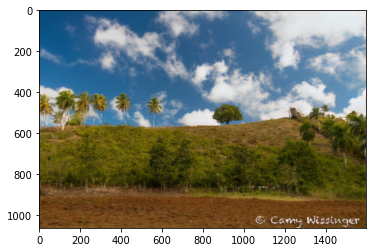

In [ ]:
im_sr = tf.squeeze(im_sr)
im_sr = image.array_to_img(im_sr)
plt.imshow(im_sr)

## Test with single image

In [ ]:
im_lr = tl.vis.read_image("/content/drive/MyDrive/AML_final_project/landscapes/sample/00000002_(2).jpg")
# im_hr = tl.vis.read_image("/content/drive/MyDrive/AML_final_project/DIV2K_train_HR/0005.png")
im_sr = evaluate(None, im_lr, None)

[TL] Input  _inputlayer_2: [1, None, None, 3]
[TL] Conv2d conv2d_38: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_39: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_34: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_40: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_35: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_18: fn: add act: No Activation
[TL] Conv2d conv2d_41: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_36: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_42: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_37: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise

ResourceExhaustedError: ignored

## Specialization

In [ ]:
G = get_G([1, None, None, 3])
G.load_weights(os.path.join(checkpoint_dir, 'g_srgan.npz'))

[TL] Input  _inputlayer_20: [1, None, None, 3]
[TL] Conv2d conv2d_389: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_390: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_348: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_391: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_349: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_159: fn: add act: No Activation
[TL] Conv2d conv2d_392: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_350: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_393: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_351: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] 

In [ ]:
G1 = get_G([1, None, None, 3])
G1.load_weights(os.path.join(checkpoint_dir, 'g.h5'))

[TL] Input  _inputlayer_21: [1, None, None, 3]
[TL] Conv2d conv2d_426: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_427: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_381: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_428: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_382: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_176: fn: add act: No Activation
[TL] Conv2d conv2d_429: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_383: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_430: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_384: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] 

In [ ]:
G.all_weights[-1]
# -0.03916182, -0.03071851, -0.02832776

<tf.Variable 'conv2d_425/biases:0' shape=(3,) dtype=float32, numpy=array([-0.02886978,  0.01332177,  0.06940488], dtype=float32)>

In [ ]:
G1.all_weights[-2]

<tf.Variable 'conv2d_462/filters:0' shape=(1, 1, 64, 3) dtype=float32, numpy=
array([[[[-0.03916182, -0.03071851, -0.02832776],
         [ 0.03995588,  0.05110621,  0.05314505],
         [-0.03448809, -0.00648117, -0.00787999],
         [ 0.05024849,  0.05763453,  0.05960436],
         [-0.03141129,  0.0337454 , -0.02111075],
         [-0.0501803 ,  0.02944714,  0.00865599],
         [ 0.0466625 ,  0.04595788,  0.05817422],
         [ 0.01861759, -0.03880924, -0.01014144],
         [ 0.05319292,  0.04458678,  0.03645763],
         [-0.08752479, -0.01399299,  0.02619315],
         [ 0.05567581, -0.02734066, -0.002193  ],
         [-0.0425154 , -0.04242229, -0.02818703],
         [-0.10341413, -0.00753833,  0.01586765],
         [-0.03238476, -0.01933264, -0.01874061],
         [-0.00471401, -0.0171559 , -0.03751802],
         [ 0.03939746,  0.00657642, -0.04320171],
         [ 0.04750923, -0.00552202, -0.0435553 ],
         [ 0.07094379,  0.05454685,  0.03600603],
         [ 0.03694464,